In [1]:
import pandas as pd
import numpy as np
import math
import shap
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight,compute_sample_weight
from astropy.coordinates import SkyCoord
import astropy.units as u
from xgboost import XGBClassifier
from grb_ml_utils import *

In [2]:
grbgen, big_table = load_big_greiner()

Columns (4,8) have mixed types.Specify dtype option on import or set low_memory=False.


In [3]:
prompt_emission = ['T90', 'z','D_L',
                   'F_g', 'HR', 'E_iso', 'L_pk', 'F_pk1',
                   'P_pk4', 'alpha_band', 'beta_band', 'E_P_band',
                   'alpha_cpl', 'E_P_cpl', 'alpha_spl','spectral_lag']
prompt_emission_no_t90 = ['z','D_L',
                   'F_g', 'HR', 'E_iso', 'L_pk', 'F_pk1',
                   'P_pk4', 'alpha_band', 'beta_band', 'E_P_band',
                   'alpha_cpl', 'E_P_cpl', 'alpha_spl','spectral_lag']
prompt_emission_no_t90_fg_hr = ['z','D_L',
                   'E_iso', 'L_pk', 'F_pk1',
                   'P_pk4', 'alpha_band', 'beta_band', 'E_P_band',
                   'alpha_cpl', 'E_P_cpl', 'alpha_spl','spectral_lag']

afterglow = ['theta_j', 'Gamma0', 'log_t_burst',
             't_b',
             'F_X11hr', 'beta_X11hr', 'F_Opt11hr',
             'T_ai', 'L_a']

host_galaxy = ['offset', 'metallicity',
               'A_V', 'SFR',
               'SSFR', 'Age', 'Mass']
host_galaxy_no_offset = ['metallicity',
               'A_V', 'SFR',
               'SSFR', 'Age', 'Mass']

all_features = prompt_emission + afterglow + host_galaxy
t90_hr = ['T90','HR']

In [4]:
for col in big_table.columns:
    print(col,np.sum(big_table[col].notna()),np.sum(big_table.loc[big_table['class']!=-1,col].notna()),np.sum(big_table.loc[big_table['class']==0,col].notna()),np.sum(big_table.loc[big_table['class']==1,col].notna()))

GRB 5453 1460 1351 109
f_GRB 265 41 39 2
Time.h.m.s. 5137 1454 1345 109
Instrument 5190 1459 1350 109
Trigger.No. 4014 1193 1096 97
coordinate 1609 1454 1345 109
error 1454 1452 1343 109
origin 0 0 0 0
SN 20 19 19 0
z 591 576 530 46
z1 56 46 46 0
z2 56 46 46 0
D_L 607 579 533 46
D_L1 0 0 0 0
D_L2 0 0 0 0
Tpre 105 40 38 2
Tpre1 105 40 38 2
Tpre2 105 40 38 2
T90 5453 1460 1351 109
T901 5453 1460 1351 109
T902 5453 1460 1351 109
T50 3853 943 875 68
T501 3825 917 849 68
T502 3825 917 849 68
T_R45 658 655 609 46
T_R451 655 652 606 46
T_R452 655 652 606 46
variability1 492 267 266 1
variability11 486 267 266 1
variability12 486 267 266 1
variability2 71 69 68 1
variability21 71 69 68 1
variability22 71 69 68 1
variability3 86 49 49 0
variability31 86 49 49 0
variability32 86 49 49 0
F_g 3799 1274 1173 101
F_g1 3794 1272 1171 101
F_g2 3794 1272 1171 101
HR 3775 1177 1076 101
HR1 3728 1175 1074 101
HR2 3728 1175 1074 101
E_iso 480 474 426 48
E_iso1 467 461 418 43
E_iso2 467 461 418 43
E_k.iso 

In [5]:
print(len(big_table))
print(np.sum(big_table['class']==0))
print(np.sum(big_table['class']==1))
print(np.sum(np.logical_and(big_table['class']==0,big_table['T90']<np.log10(2))))
print(np.sum(np.logical_and(big_table['class']==1,big_table['T90']>np.log10(2))))
print(np.sum(np.logical_and(big_table['T90']>np.log10(1),big_table['T90']<np.log10(4))))
print(np.sum(np.logical_and(np.logical_and(big_table['T90']>np.log10(1),big_table['T90']<np.log10(4)),big_table['class']==0)))
print(np.sum(np.logical_and(np.logical_and(big_table['T90']>np.log10(1),big_table['T90']<np.log10(4)),big_table['class']==1)))

5453
1351
109
46
15
516
77
21


In [9]:
def plot_model(file_name,columns_to_use,tree_model=False):
    data_pd = big_table[big_table['class']!=-1]
    rows_to_use = np.zeros(len(data_pd),dtype=bool)
    for feature in columns_to_use:
        if feature=='T90':
            continue
        rows_to_use = np.logical_or(rows_to_use,data_pd[feature].notnull())
    data_pd = data_pd[rows_to_use].reset_index()

    intermingled_rows_to_use = np.logical_or(np.logical_and(data_pd['T90']>np.log10(2),data_pd['class']==1),np.logical_and(data_pd['T90']<np.log10(2),data_pd['class']==0))
    intermingled_list = intermingled_rows_to_use.index[intermingled_rows_to_use].to_numpy()
    intermediate_rows_to_use = np.logical_and(data_pd['T90']>np.log10(1),data_pd['T90']<np.log10(4))
    intermediate_list = intermediate_rows_to_use.index[intermediate_rows_to_use].to_numpy()
    data_feature = data_pd[columns_to_use]
    data_target = data_pd['class'].to_numpy()

    X,test_X,y,test_y = train_test_split(data_feature,data_target,test_size=0.3,stratify=data_target)
    
    if tree_model:
        clf = DecisionTreeClassifier(max_depth=3)
    else:
        clf = XGBClassifier(use_label_encoder=False,eval_metric='logloss')
    
    sample_weight = compute_sample_weight('balanced',y=y)
    clf.fit(X, y,sample_weight=sample_weight)
    predictions = clf.predict(test_X)
    print('all,accu:' + str(accuracy_score(test_y,predictions)))
    print('all,f1:' + str(f1_score(test_y,predictions)))
    categories = ['Type II', 'Type I']
    cf = confusion_matrix(test_y, predictions)
    make_confusion_matrix(cf, 
                          categories=categories,
                          cmap=plt.cm.viridis,
                          figsize=(5,4),
                          sum_stats=None)
    
    intermingled_feature = data_pd.loc[intermingled_rows_to_use,columns_to_use]
    intermingled_target = data_pd.loc[intermingled_rows_to_use,'class']
    intermingled_predictions = clf.predict(intermingled_feature)
    print('inter,accu:' + str(accuracy_score(intermingled_target,intermingled_predictions)))
    print('inter,f1:' + str(f1_score(intermingled_target,intermingled_predictions)))
    categories = ['Type II', 'Type I']
    cf = confusion_matrix(intermingled_target,intermingled_predictions)
    make_confusion_matrix(cf, 
                          categories=categories,
                          cmap=plt.cm.viridis,
                          figsize=(5,4),
                          sum_stats=None)
    
    intermediate_feature = data_pd.loc[intermediate_rows_to_use,columns_to_use]
    intermediate_target = data_pd.loc[intermediate_rows_to_use,'class']
    intermediate_predictions = clf.predict(intermediate_feature)
    print('mediate,accu:' + str(accuracy_score(intermediate_target,intermediate_predictions)))
    print('mediate,f1:' + str(f1_score(intermediate_target,intermediate_predictions)))
    categories = ['Type II', 'Type I']
    cf = confusion_matrix(intermediate_target,intermediate_predictions)
    make_confusion_matrix(cf, 
                          categories=categories,
                          cmap=plt.cm.viridis,
                          figsize=(5,4),
                          sum_stats=None)
    
    if tree_model:
        pass
    else:
        explainer = shap.Explainer(clf, X)
        shap_values = explainer(X)
        plt.figure()
        shap.plots.bar(shap_values)
        plt.tight_layout()
        plt.figure()
        shap.plots.beeswarm(shap_values)
        plt.tight_layout()
    return

all,accu:0.9676616915422885
all,f1:0.8059701492537312
inter,accu:0.803921568627451
inter,f1:0.6666666666666667
mediate,accu:0.9662921348314607
mediate,f1:0.9268292682926829


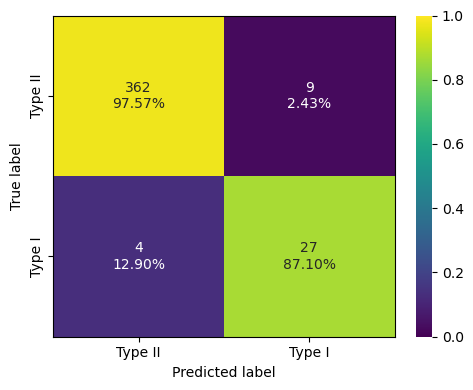

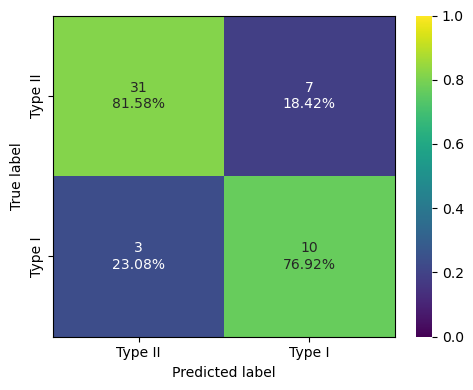

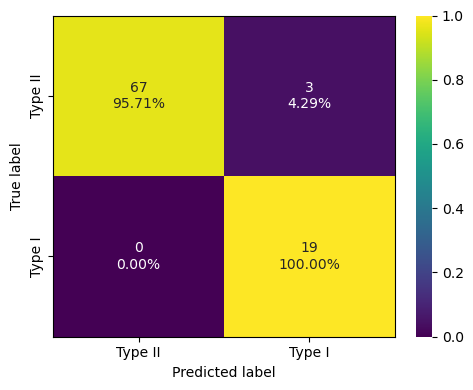

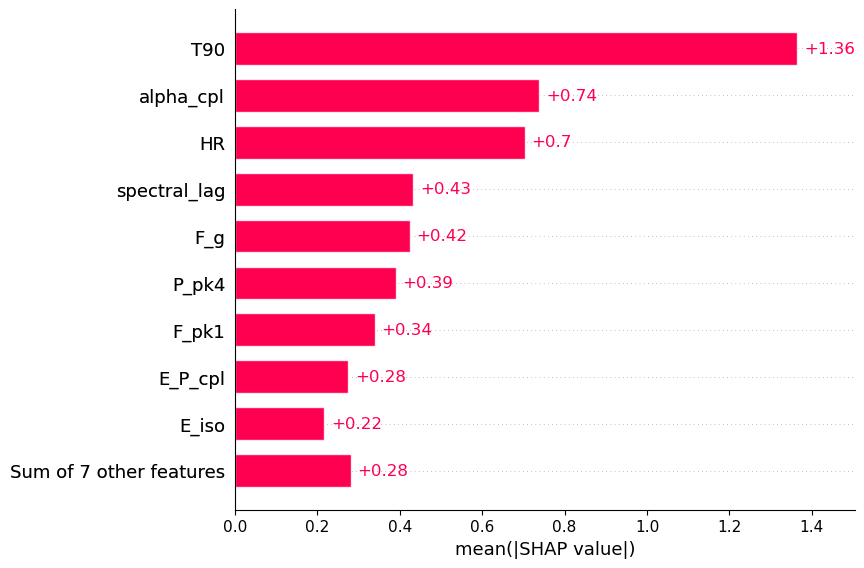

<Figure size 640x480 with 0 Axes>

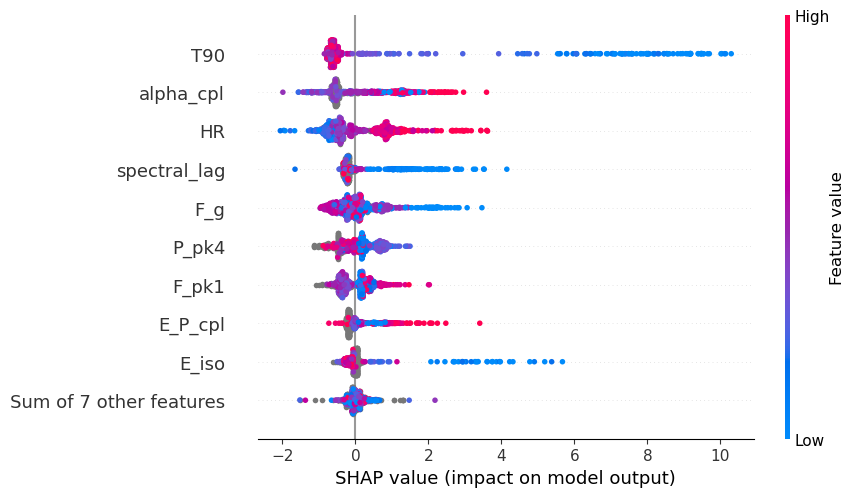

<Figure size 640x480 with 0 Axes>

In [10]:
file_name = 'prompt'
columns_to_use = prompt_emission
plot_model(file_name,columns_to_use)

all,accu:0.9626865671641791
all,f1:0.7619047619047619
inter,accu:0.8627450980392157
inter,f1:0.7741935483870968
mediate,accu:0.9438202247191011
mediate,f1:0.8717948717948718


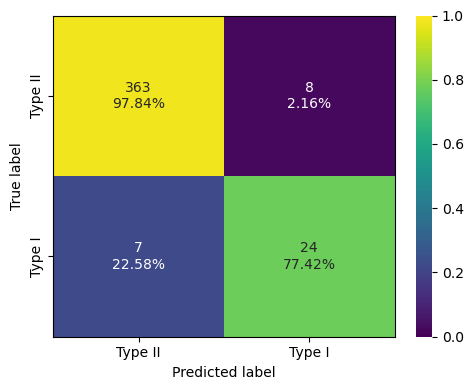

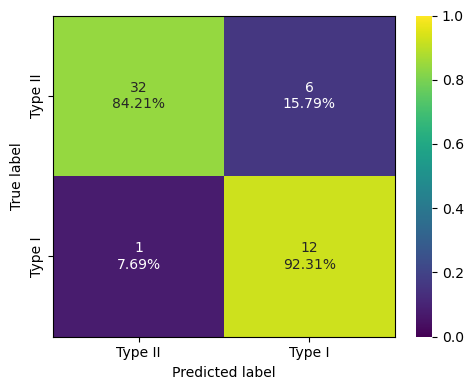

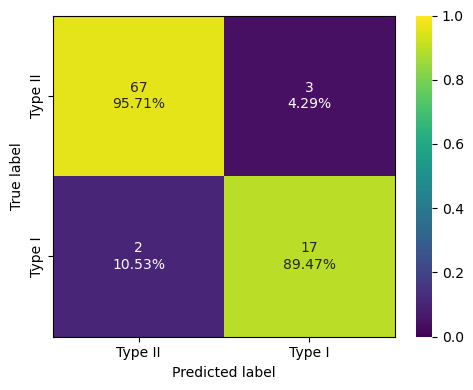

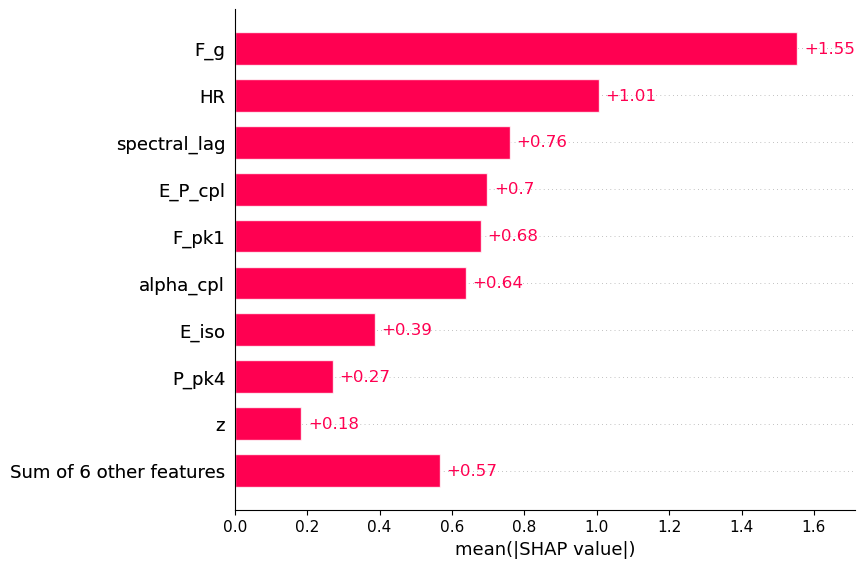

<Figure size 640x480 with 0 Axes>

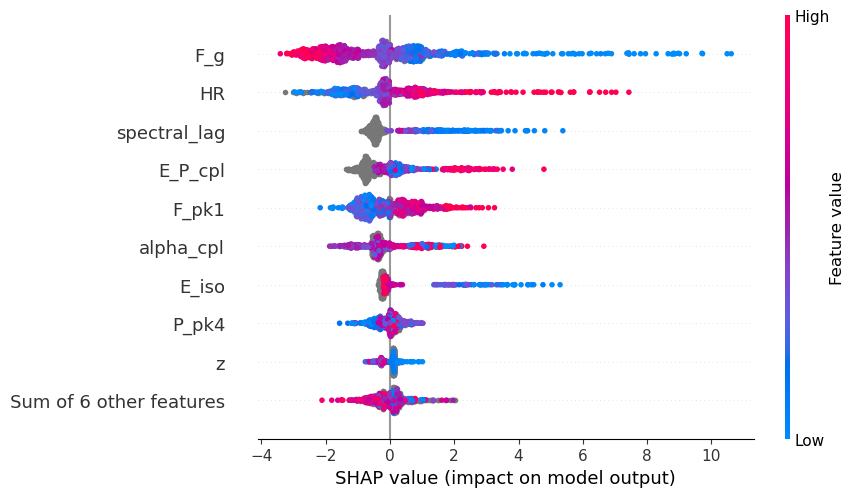

<Figure size 640x480 with 0 Axes>

In [11]:
file_name = 'prompt_no_t90'
columns_to_use = prompt_emission_no_t90
plot_model(file_name,columns_to_use)

all,accu:0.9203980099502488
all,f1:0.36
inter,accu:0.9019607843137255
inter,f1:0.8
mediate,accu:0.9213483146067416
mediate,f1:0.7999999999999999


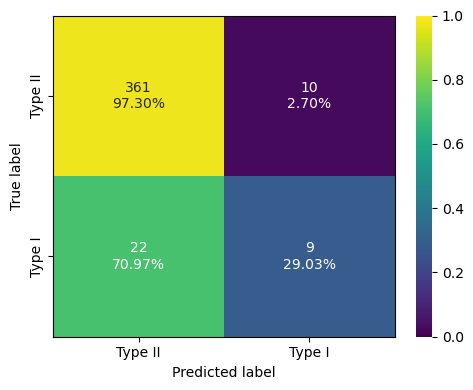

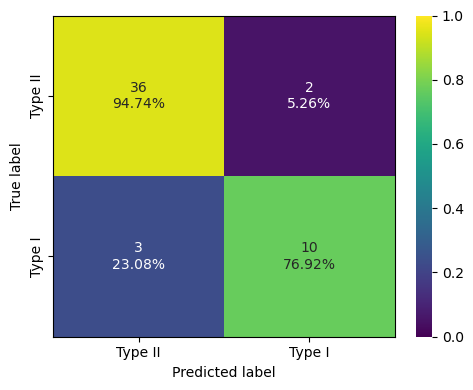

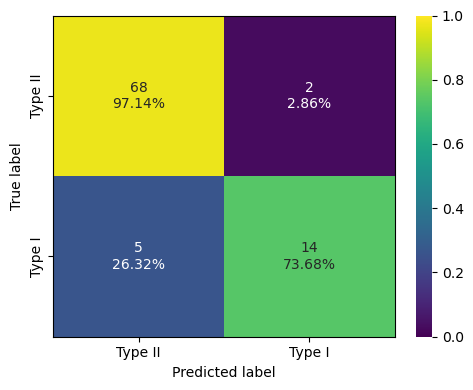

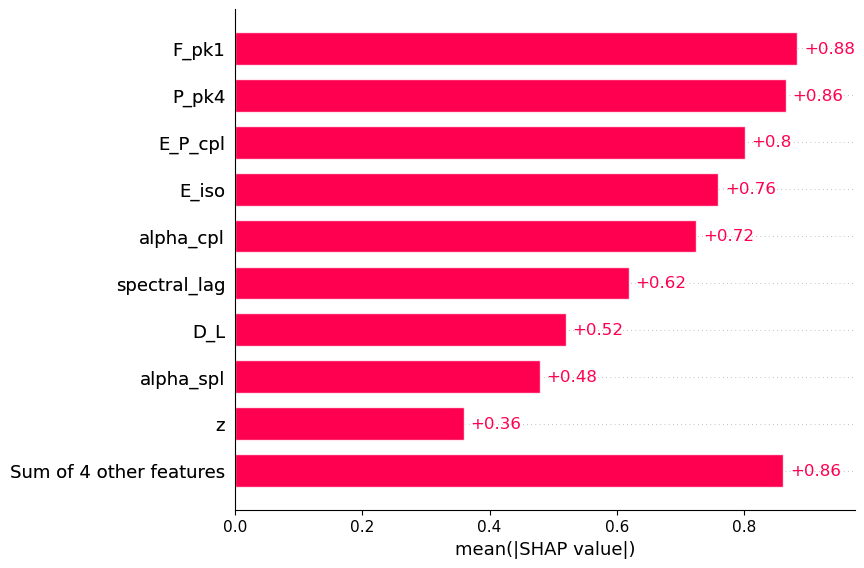

<Figure size 640x480 with 0 Axes>

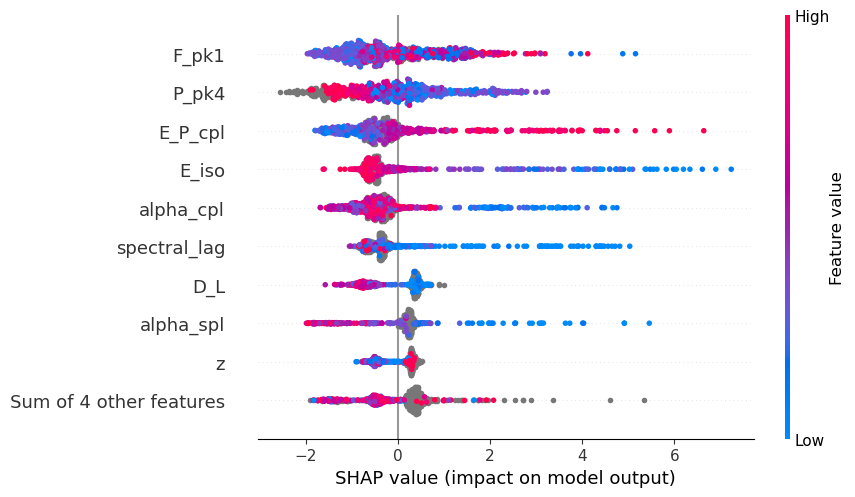

<Figure size 640x480 with 0 Axes>

In [12]:
file_name = 'prompt_no_t90_fg_hr'
columns_to_use = prompt_emission_no_t90_fg_hr
plot_model(file_name,columns_to_use)

all,accu:0.9386792452830188
all,f1:0.43478260869565216
inter,accu:0.7857142857142857
inter,f1:0.7692307692307693
mediate,accu:0.9333333333333333
mediate,f1:0.8571428571428571


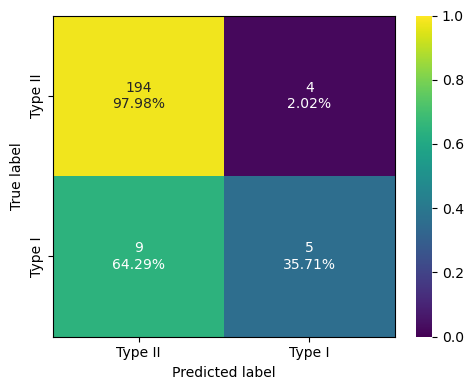

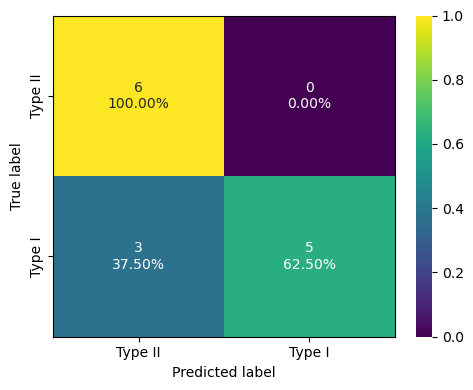

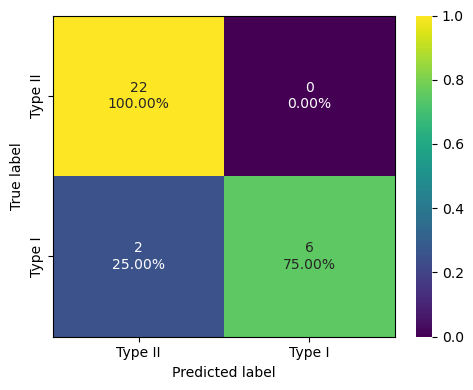

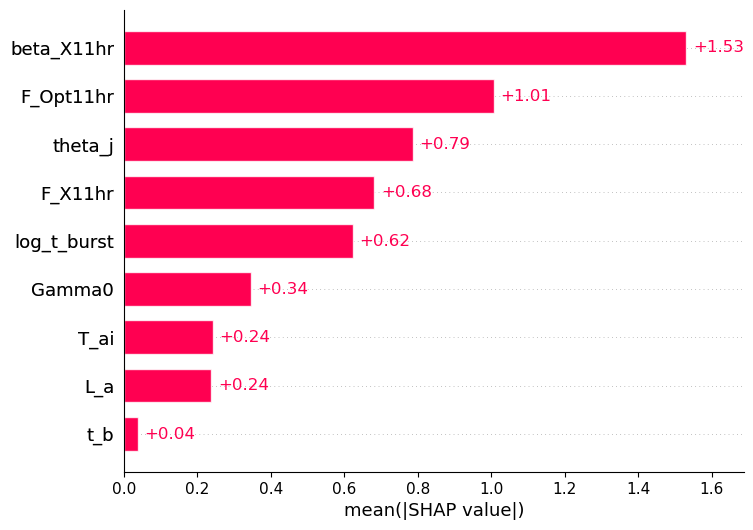

<Figure size 640x480 with 0 Axes>

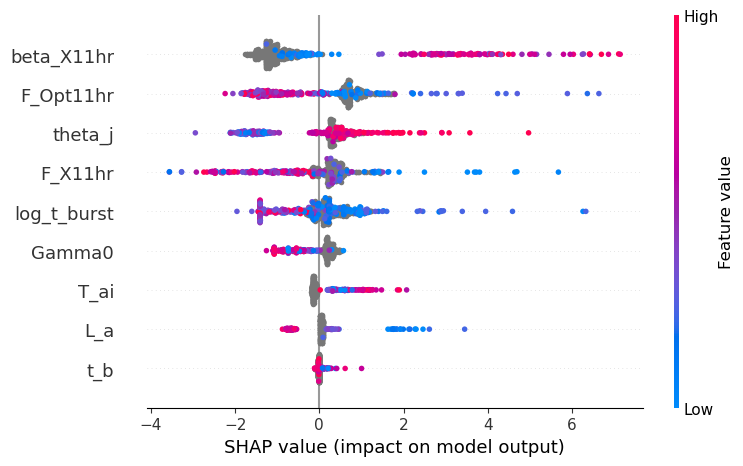

<Figure size 640x480 with 0 Axes>

In [13]:
file_name = 'afterglow'
columns_to_use = afterglow
plot_model(file_name,columns_to_use)

all,accu:0.9327731092436975
all,f1:0.6363636363636365
inter,accu:0.9090909090909091
inter,f1:0.9090909090909091
mediate,accu:1.0
mediate,f1:1.0


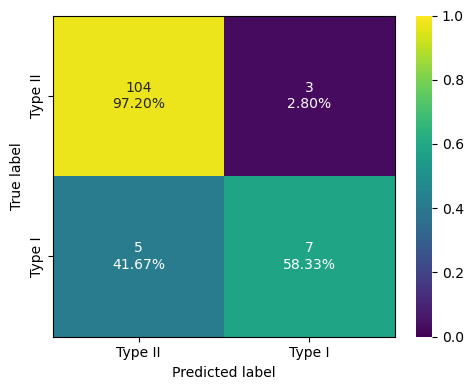

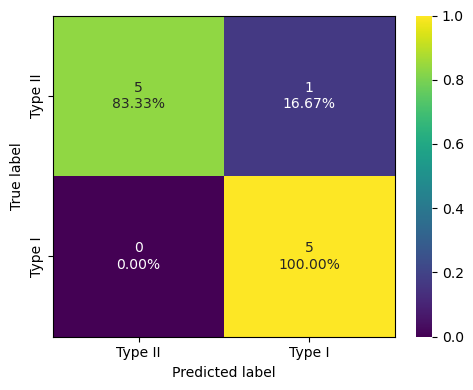

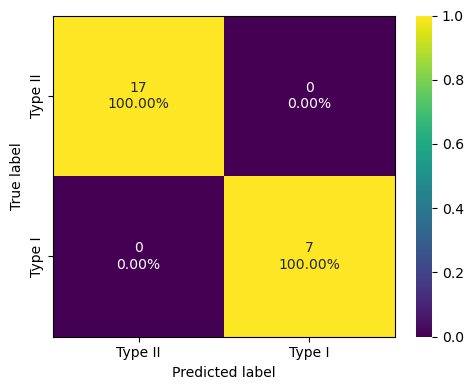

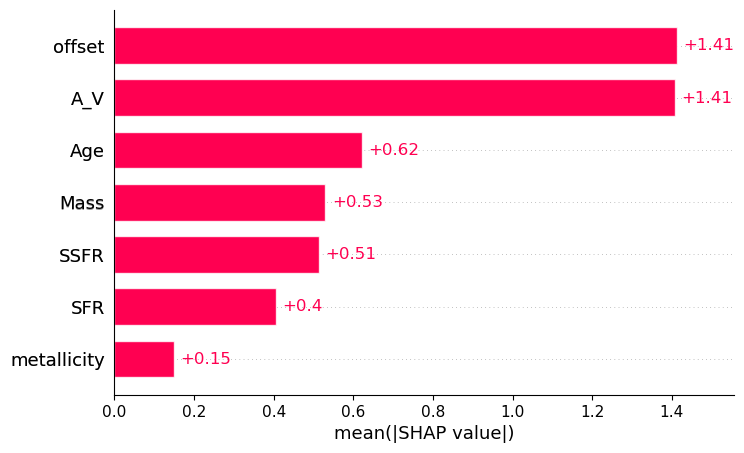

<Figure size 640x480 with 0 Axes>

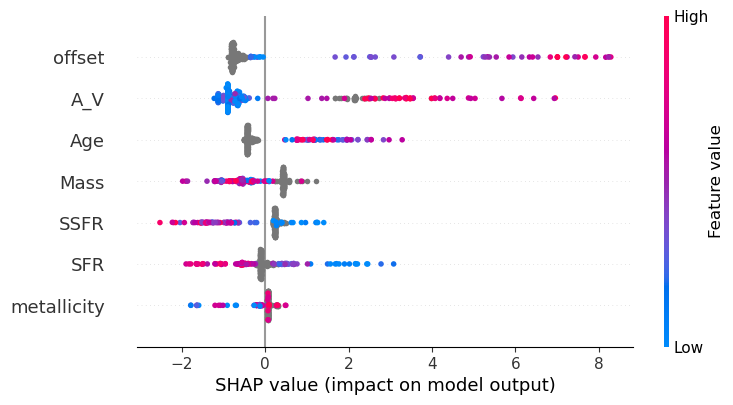

<Figure size 640x480 with 0 Axes>

In [14]:
file_name = 'host'
columns_to_use = host_galaxy
plot_model(file_name,columns_to_use)

all,accu:0.8823529411764706
all,f1:0.4615384615384615
inter,accu:1.0
inter,f1:1.0
mediate,accu:0.9583333333333334
mediate,f1:0.923076923076923


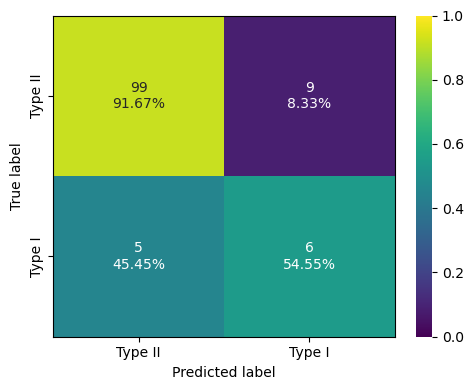

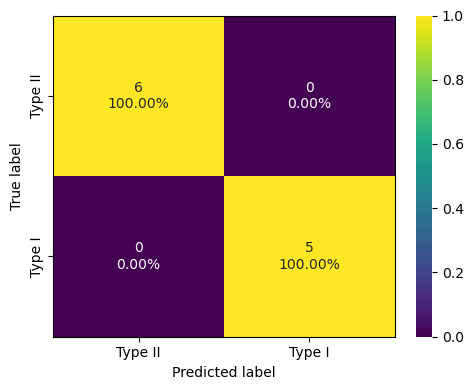

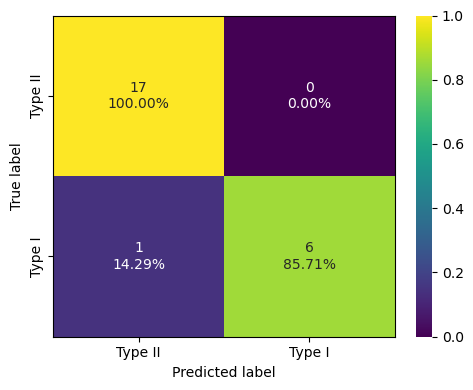

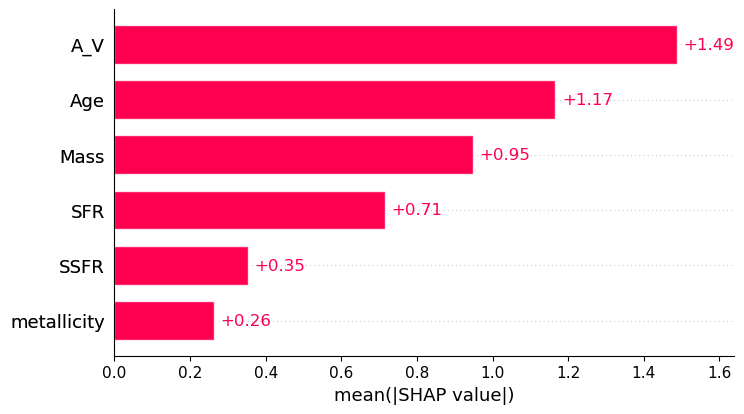

<Figure size 640x480 with 0 Axes>

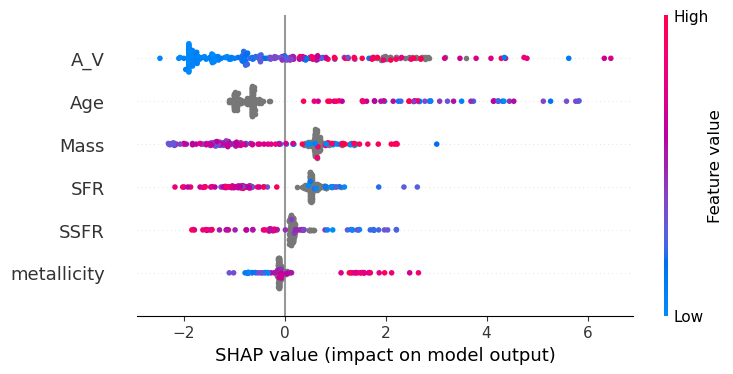

<Figure size 640x480 with 0 Axes>

In [15]:
file_name = 'host_no_offset'
columns_to_use = host_galaxy_no_offset
plot_model(file_name,columns_to_use)

all,accu:0.9656862745098039
all,f1:0.7586206896551724
inter,accu:0.8431372549019608
inter,f1:0.7142857142857142
mediate,accu:0.9333333333333333
mediate,f1:0.8235294117647058


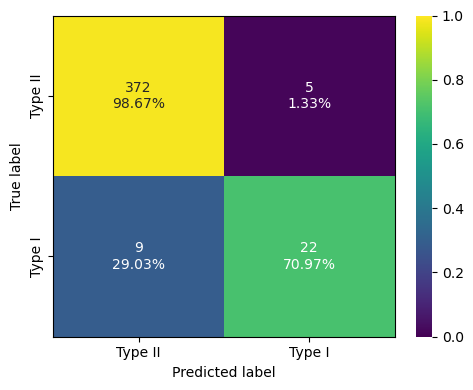

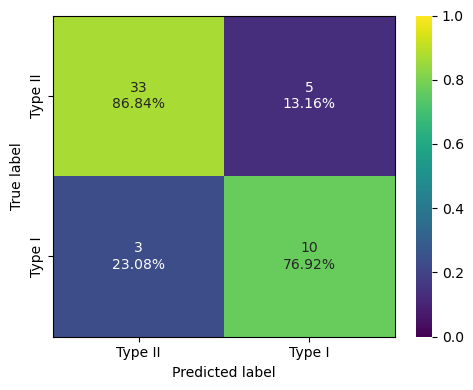

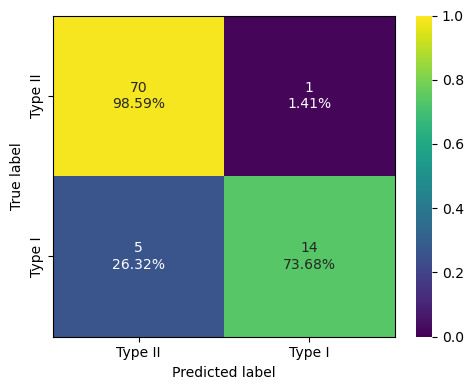

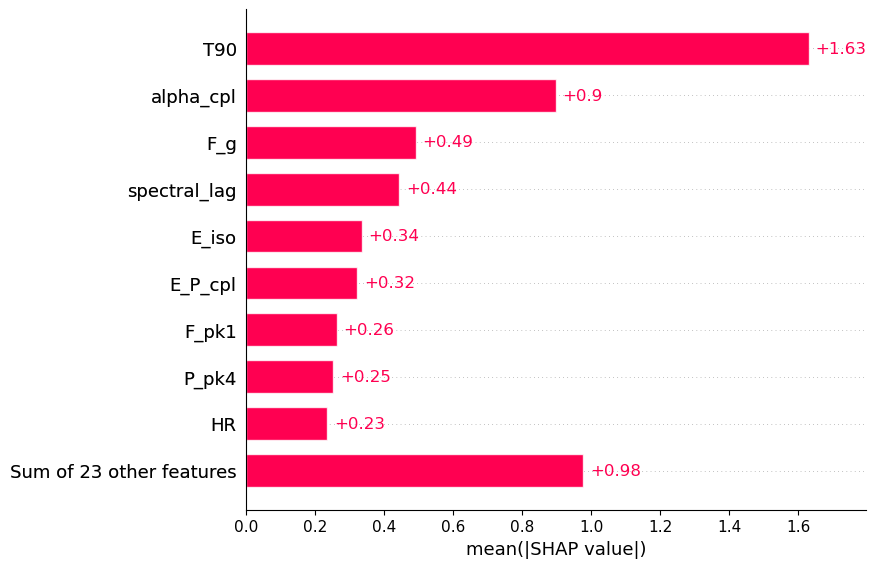

<Figure size 640x480 with 0 Axes>

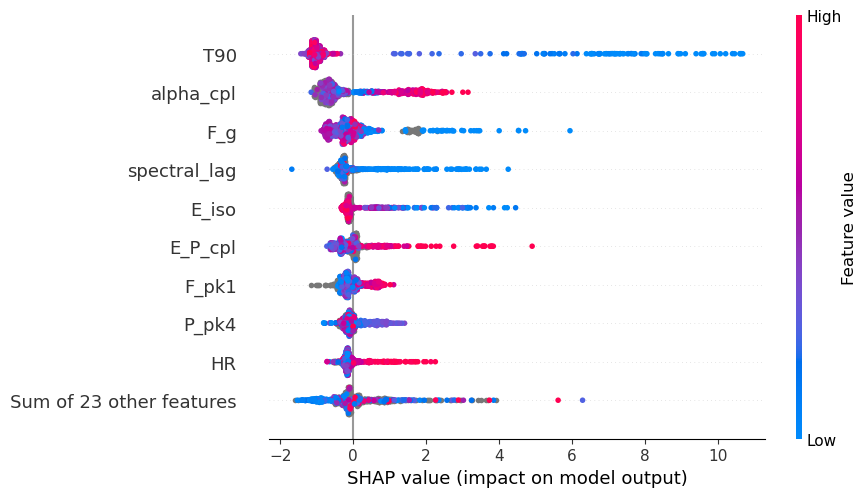

<Figure size 640x480 with 0 Axes>

In [16]:
file_name = 'all'
columns_to_use = all_features
plot_model(file_name,columns_to_use)

all,accu:0.943502824858757
all,f1:0.696969696969697
inter,accu:0.16326530612244897
inter,f1:0.163265306122449
mediate,accu:0.6582278481012658
mediate,f1:0.5573770491803278


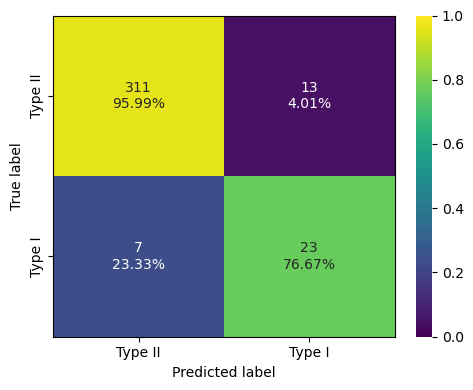

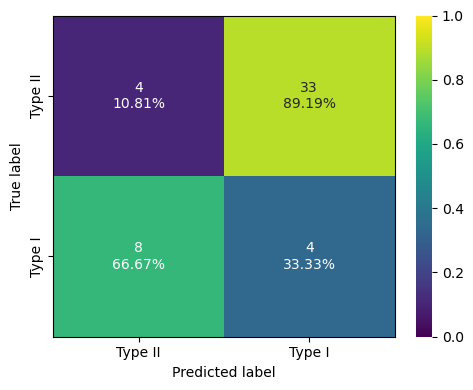

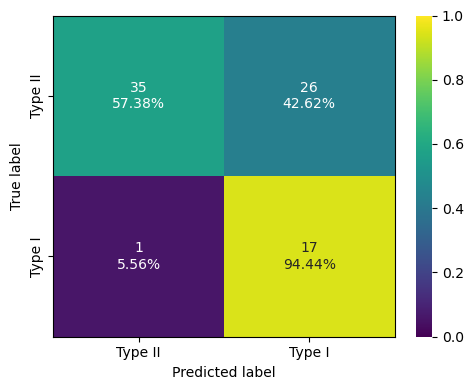

In [17]:
file_name = 'tree'
columns_to_use = t90_hr
plot_model(file_name,columns_to_use,tree_model=True)